Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [5]:
data = df['Passengers'].values.astype('float32')
data[:5]

array([112., 118., 132., 129., 121.], dtype=float32)

Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [9]:
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[:train_size], data[train_size:]
print(train[:5])
print(test[:5])

[112. 118. 132. 129. 121.]
[315. 301. 356. 348. 355.]


**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [18]:
import torch
def create_dataset(dataset, lookback=1):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        X.append(dataset[i:(i + lookback)])
        y.append(dataset[i + lookback])
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    return X, y

In [19]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [22]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(AirModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = AirModel(hidden_size=50, num_layers=1)
test_input = torch.tensor([[112.]], dtype=torch.float32).unsqueeze(0)
output = model(test_input)
print(output)


tensor([[-0.1904]], grad_fn=<AddmmBackward0>)


**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [23]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

for X_batch, y_batch in train_loader:
    print("Розмір X_batch:", X_batch.shape)
    print("Розмір y_batch:", y_batch.shape)
    break


Розмір X_batch: torch.Size([8, 1])
Розмір y_batch: torch.Size([8, 1])


**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [24]:
import torch.optim as optim

num_epochs = 2000
learning_rate = 0.001
model = AirModel(hidden_size=50, num_layers=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.unsqueeze(-1)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train.unsqueeze(-1))
            train_rmse = torch.sqrt(criterion(train_pred, y_train)).item()
            test_pred = model(X_test.unsqueeze(-1))
            test_rmse = torch.sqrt(criterion(test_pred, y_test)).item()

        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")


Epoch 0: train RMSE 226.0482, test RMSE 422.4921
Epoch 100: train RMSE 187.8320, test RMSE 382.4896
Epoch 200: train RMSE 156.9667, test RMSE 349.3351
Epoch 300: train RMSE 129.8072, test RMSE 318.8400
Epoch 400: train RMSE 106.6994, test RMSE 290.7319
Epoch 500: train RMSE 88.4272, test RMSE 265.3799
Epoch 600: train RMSE 72.1350, test RMSE 241.1578
Epoch 700: train RMSE 58.6167, test RMSE 218.3548
Epoch 800: train RMSE 48.1729, test RMSE 197.7081
Epoch 900: train RMSE 40.8557, test RMSE 179.2412
Epoch 1000: train RMSE 34.8479, test RMSE 162.9393
Epoch 1100: train RMSE 30.6522, test RMSE 148.9405
Epoch 1200: train RMSE 29.1708, test RMSE 137.2892
Epoch 1300: train RMSE 26.3794, test RMSE 128.4858
Epoch 1400: train RMSE 25.5188, test RMSE 121.1840
Epoch 1500: train RMSE 25.2353, test RMSE 115.5212
Epoch 1600: train RMSE 24.3546, test RMSE 111.9789
Epoch 1700: train RMSE 24.1907, test RMSE 108.3304
Epoch 1800: train RMSE 24.1643, test RMSE 104.5683
Epoch 1900: train RMSE 23.6143, test R

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

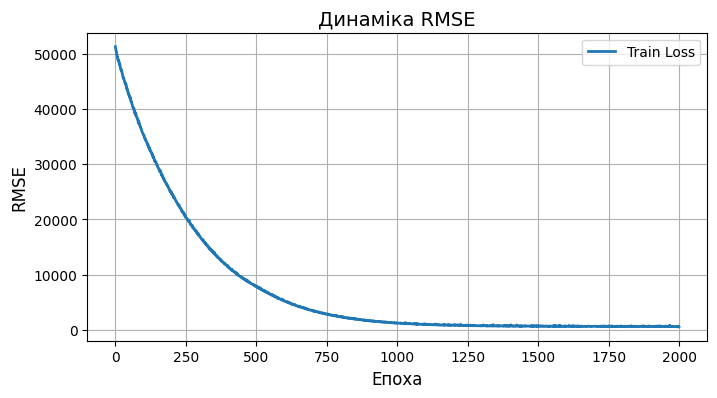

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(losses, label='Train Loss', linewidth=2)
plt.title('Динаміка RMSE', fontsize=14)
plt.xlabel('Епоха', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Загалом можна сказати, що модель навчилася, оскільки RMSE спадає, після чого стабілізується на певному рівні. Проте RMSE після стабілізації досить високий, на рівні 20-30

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

/tmp/ipython-input-1781421010.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_plot[lookback:train_size] = y_pred[:, 0]  # беремо перший (і єдиний) вихід
/tmp/ipython-input-1781421010.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_plot[train_size+lookback:len(timeseries)] = y_pred_test[:, 0]


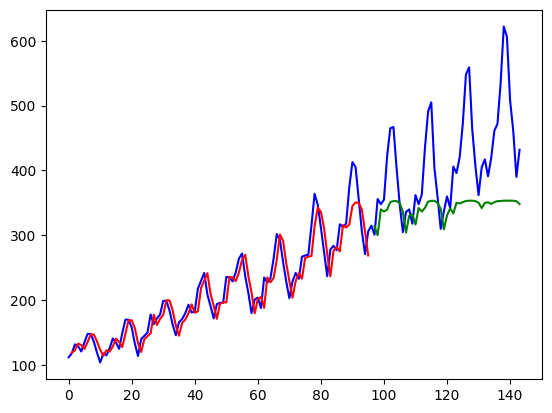

In [34]:
timeseries = data
def plot_predicts():
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_train.unsqueeze(-1))
      train_plot[lookback:train_size] = y_pred[:, 0]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(timeseries) * np.nan
      y_pred_test = model(X_test.unsqueeze(-1))
      test_plot[train_size+lookback:len(timeseries)] = y_pred_test[:, 0]

  # Візуалізація результатів
  plt.plot(timeseries, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts()

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [36]:
model_hs100 = AirModel(hidden_size=100, num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_hs100.parameters(), lr=0.001)
num_epochs = 2000
losses_hs100 = []
for epoch in range(num_epochs):
    model_hs100.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.unsqueeze(-1)
        outputs = model_hs100(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    losses_hs100.append(epoch_loss)

    if epoch % 100 == 0:
        model_hs100.eval()
        with torch.no_grad():
            train_rmse = torch.sqrt(criterion(model_hs100(X_train.unsqueeze(-1)), y_train)).item()
            test_rmse = torch.sqrt(criterion(model_hs100(X_test.unsqueeze(-1)), y_test)).item()
        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")


Epoch 0: train RMSE 225.6866, test RMSE 422.0791
Epoch 100: train RMSE 150.4049, test RMSE 342.1167
Epoch 200: train RMSE 100.6580, test RMSE 282.7279
Epoch 300: train RMSE 70.6736, test RMSE 238.4927
Epoch 400: train RMSE 51.0144, test RMSE 201.6444
Epoch 500: train RMSE 38.2403, test RMSE 172.3312
Epoch 600: train RMSE 31.5448, test RMSE 149.2343
Epoch 700: train RMSE 29.7437, test RMSE 131.2858
Epoch 800: train RMSE 27.0236, test RMSE 118.5314
Epoch 900: train RMSE 24.6620, test RMSE 111.4820
Epoch 1000: train RMSE 24.2579, test RMSE 104.0603
Epoch 1100: train RMSE 24.8978, test RMSE 101.5139
Epoch 1200: train RMSE 23.9200, test RMSE 96.5583
Epoch 1300: train RMSE 25.2799, test RMSE 95.2354
Epoch 1400: train RMSE 23.6558, test RMSE 92.8318
Epoch 1500: train RMSE 23.1684, test RMSE 90.9182
Epoch 1600: train RMSE 23.7006, test RMSE 89.2598
Epoch 1700: train RMSE 22.9693, test RMSE 88.9115
Epoch 1800: train RMSE 23.3544, test RMSE 89.5434
Epoch 1900: train RMSE 22.8820, test RMSE 87.40

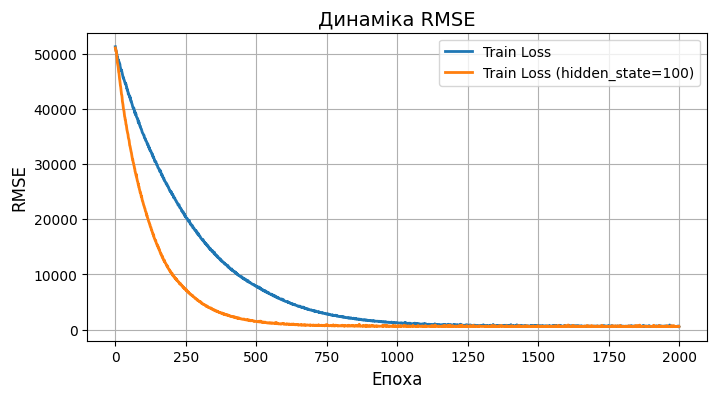

In [38]:
plt.figure(figsize=(8, 4))
plt.plot(losses, label='Train Loss', linewidth=2)
plt.plot(losses_hs100, label='Train Loss (hidden_state=100)', linewidth=2)
plt.title('Динаміка RMSE', fontsize=14)
plt.xlabel('Епоха', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Нова модель навчається швидше, але стабілізується приблизно на тому самому рівні, що і попередня